In [1]:
"""
Used for ploting csv data
"""

'\nUsed for ploting csv data\n'

In [2]:
# imports
import time
import pandas as pd
import lib.base_strategy as bs
import lib.init_data_helper as idh
from fractions import Fraction as frac
from tests.test_all_tests import get_test_data_path

from lib.get_binance_data import get_binance_data
from lib.get_coinbase_data import get_coinbase_data

In [3]:
# Read in csv's

# Collect these files from Kaggle here:
# https://www.kaggle.com/yamqwe/cryptocurrency-extra-data-ethereum
list_of_csv = [
    # TODO: figure out problems with 2017 data
    # 'full_data__6__2017.csv', # don't use 2017 data, its not great
    'full_data__6__2018.csv',
    'full_data__6__2019.csv',
    'full_data__6__2020.csv',
    'full_data__6__2021.csv'
]
sorted_list_of_csv = [
    # 'sorted_full_data_2017.csv',
    'sorted_full_data_2018.csv',
    'sorted_full_data_2019.csv',
    'sorted_full_data_2020.csv',
    'sorted_full_data_2021.csv'
]

In [4]:
# Get CoinBase Data - Takes around ~330 min

# Make sure we actually want to get the data
get_data = True
if get_data:
    # Split data collection into two parts so that it doesn't error out
    part_1 = get_coinbase_data(start_date='2018-01-01-00-00', end_date='2020-01-1-00-00')
    # Don't pass end_date to use current time as end
    part_2 = get_coinbase_data(start_date='2020-01-01-00-00')
    print('Querying complete.')

    # Combine parts
    coinbase_data = idh.combine_datasets(part_1, part_2)
    # drop index so we don't get two index columns
    coinbase_data = coinbase_data.drop(columns=['index'])
    print('Combining data complete.')
    # Give index a name
    coinbase_data.index.names = ['index']

    # Save data
    print(f'\nHistorical values found: {len(coinbase_data.index)}')
    coinbase_data.to_csv(bs.full_path('CoinBase_ETH_all_price_data'))
    print(f'\nSubset of final data:\n{coinbase_data.tail(5)}')
    print('Done!')



Subset of data:
   index   timestamp                  fraction_price  decimal_price
0      0  1514764860                          1479/2       739.5000
1      1  1514764920  1625809361085399/2199023255552       739.3325
2      2  1514764980   812789231821783/1099511627776       739.2275
3      3  1514765040  6505480448062259/8796093022208       739.5875
4      4  1514765100  3252025541473075/4398046511104       739.4250

Subset of data:
   index   timestamp                   fraction_price  decimal_price
0      0  1577836800  4520312204112691/35184372088832       128.4750
1      1  1577836860  4517937258996695/35184372088832       128.4075
2      2  1577836920  2258440863917015/17592186044416       128.3775
3      3  1577836980                           1027/8       128.3750
4      4  1577837040  2258352902986793/17592186044416       128.3725
Querying complete.
Combining data complete.

Historical values found: 2151815

Subset of final data:
          timestamp                  fracti

In [5]:
# Get Binance Data - Takes around ~80 min

# Make sure we actually want to get the data
get_data = True
if get_data:
    # USDT has more historical price data than USDC but either can be used
    TRADING_PAIR = 'ETHUSDT'
    # TRADING_PAIR = 'ETHUSDC'
    if TRADING_PAIR == 'ETHUSDT':
        ## For ETH USDT
        # Earliest timestamp found: 1502942400.0
        # Human readable format: Wed Aug 16 21:00:00 2017
        # However, early Binance ETH USDT data is not very good so only use 2018+ (aka 1514764800+)
        # Multiply by 1000 to make what we would get from the query
        start_date = 1514764800*1000
        # For ETH USDC (not quite as much data as USDT)
        # Earliest timestamp found: 1544844060.0
        # Human readable format: Fri Dec 14 19:21:00 2018
    else:
        start_date = ''

    klines = get_binance_data(TRADING_PAIR, start_date)

    # save data as a file
    save_file_name = 'csv_files/Binance_ETH_all_price_data.csv'
    with open(save_file_name, 'w') as d:
        d.write('index,timestamp,fraction_price,decimal_price\n')
        # add index column
        ind = 0
        for line in klines:
            fraction_price = frac(
                float(line[1])+
                float(line[2])+
                float(line[3])+
                float(line[4])
            )/4
            decimal_price = bs.unfrac(fraction_price)
            # Divide timestamp by 1000 so we can remove three 000s from the timestamp.
            # This makes the timestamp units seconds which matches the other data we have.
            d.write(f'{ind},{int(int(line[0])/1000)},{fraction_price},{decimal_price}\n')
            # keep track of index
            ind += 1

Historical values found: 2162675
Subset of data:
[[1514764800000, '733.01000000', '733.97000000', '732.75000000', '732.75000000', '19.77247000', 1514764859999, '14490.96159590', 29, '1.74674000', '1281.80363500', '0'], [1514764860000, '733.34000000', '734.52000000', '732.51000000', '732.51000000', '26.05199000', 1514764919999, '19105.09809430', 50, '21.31950000', '15638.00736340', '0'], [1514764920000, '732.51000000', '734.49000000', '732.49000000', '732.51000000', '15.71883000', 1514764979999, '11515.44003840', 40, '3.12611000', '2291.04390440', '0'], [1514764980000, '732.51000000', '733.83000000', '730.00000000', '730.36000000', '29.43683000', 1514765039999, '21532.60826810', 59, '3.50540000', '2567.13200620', '0'], [1514765040000, '730.36000000', '731.00000000', '728.93000000', '728.93000000', '42.50766000', 1514765099999, '31036.17094880', 103, '17.01968000', '12429.25441230', '0']]


In [6]:
# Test if csv are sorted
for csv in list_of_csv:
    data = pd.read_csv(bs.full_path(csv))
    sorted_data = data.sort_values(by=['timestamp'])
    print(f'{csv} is sorted?: {data.equals(sorted_data)}')
    # The above resulted in 
    # full_data__6__2018.csv is sorted?: True
    # full_data__6__2019.csv is sorted?: False
    # full_data__6__2020.csv is sorted?: False
    # full_data__6__2021.csv is sorted?: False
    # So we have to sort the data (only do this once)
    
    # Test for nulls
    null_counts = sorted_data[['timestamp', 'Open', 'Close', 'High', 'Low']].isnull().sum()
    null_counts[null_counts > 0].sort_values(ascending=False)
    print('Null values found:')
    print(null_counts)
    # No nulls!

    # Create 'price' column from avg of Open and Close
    # First make the row and round to 4 decimals
    # Divide by 4 after we make the fraction_price
    sorted_data['decimal_price'] = round(sorted_data['Open'] + sorted_data['Close'] + sorted_data['High'] + sorted_data['Low'],
         4)
    # Then fractionalize the number to minimize floating point rounding errors
    sorted_data['fraction_price'] = sorted_data['decimal_price'].apply(lambda x: frac(x)/4)
    # Average out decimal price
    sorted_data['decimal_price'] = sorted_data['decimal_price']/4
    # Give the index a name for the csv
    sorted_data.index.names = ['index']
    # drop all columns we don't want
    sorted_data = sorted_data.filter(['index', 'timestamp', 'fraction_price', 'decimal_price'])
    # Only run this once
    # NOTE: Uncomment this when running for the first time
    sorted_data.to_csv(bs.full_path('sorted_full_data_'+ csv[-8:]))

# Spacing
print('\nSorted check:')
# Show that sorted data is sorted
for csv in sorted_list_of_csv:
    data = pd.read_csv(bs.full_path(csv))
    sorted_data = data.sort_values(by=['timestamp'])
    print(f'{csv} is sorted?: {data.equals(sorted_data)}')



full_data__6__2018.csv is sorted?: True
Null values found:
timestamp    0
Open         0
Close        0
High         0
Low          0
dtype: int64
full_data__6__2019.csv is sorted?: False
Null values found:
timestamp    0
Open         0
Close        0
High         0
Low          0
dtype: int64
full_data__6__2020.csv is sorted?: False
Null values found:
timestamp    0
Open         0
Close        0
High         0
Low          0
dtype: int64
full_data__6__2021.csv is sorted?: False
Null values found:
timestamp    0
Open         0
Close        0
High         0
Low          0
dtype: int64

Sorted check:
sorted_full_data_2018.csv is sorted?: True
sorted_full_data_2019.csv is sorted?: True
sorted_full_data_2020.csv is sorted?: True
sorted_full_data_2021.csv is sorted?: True


In [7]:
# Combine ALL data into one big file

# initialize list of all of the files we want to look at
overall_list = [
    'Binance_ETH_all_price_data.csv',
    'CoinBase_ETH_all_price_data.csv'
]
# add the Kaggle data to our list
overall_list = overall_list + sorted_list_of_csv

# initialize empty dataframe to hold all the values
combined_df = pd.DataFrame(columns=['index', 'timestamp', 'fraction_price', 'decimal_price'])

# combine all the data into one dataset
for csv in overall_list:
    print(f'Adding {csv}')
    new_data = pd.read_csv(bs.full_path(csv))
    combined_df = idh.combine_datasets(combined_df, new_data)

# Drop the fake index
combined_df = combined_df.drop(columns=['index'])
# Name the real index for the csv
combined_df.index.names = ['index']

# save result to a file
combined_df.to_csv('csv_files/Combined_ETH_all_price_data.csv')
print('Results Saved!\n')

# Check if we have any timestamp gaps in our data
# Ideally we would only see the final timestamp printed
idh.check_missing_timestamp(combined_df)

Adding Binance_ETH_all_price_data.csv
Adding CoinBase_ETH_all_price_data.csv
Adding sorted_full_data_2018.csv
Adding sorted_full_data_2019.csv
Adding sorted_full_data_2020.csv
Adding sorted_full_data_2021.csv
Results Saved!

Missing timestamps (add 60 sec): 
index
59160      1518242354
2171861    1645004400
Number of missing timestamps: 2
Ignore last timestamp of: 1645004400



In [8]:
# idh.create_price_period('1/1/2018','1/5/2018', 'test')
# idh.create_price_period('1/1/2018','2/1/2018', 'test_month')

# --- Specific price_periods --- 
# Yearly
idh.create_price_period('1/1/2018','1/1/2019', '2018_price_data')
idh.create_price_period('1/1/2019','1/1/2020', '2019_price_data')
idh.create_price_period('1/1/2020','1/1/2021', '2020_price_data')
idh.create_price_period('1/1/2021','1/1/2022', '2021_price_data') 
# Past 4 Years - 2018 through 2021
idh.create_price_period('1/1/2018', '1/1/2022', '2018-2021')
# Past 3 Years - 2019 through 2021
idh.create_price_period('1/1/2019', '1/1/2022', '2019-2021')
# Past 2 Years - 2020 through 2021
idh.create_price_period('1/1/2020', '1/1/2022', '2020-2021')
# Past 1 Year - all of 2021 # Low to high to low to high
idh.create_price_period('1/1/2021', '1/1/2022', '2021')

# High to low 
# - 1515870180 (max of 2018) to end of 2018
idh.create_price_period(1515870180, 1546300740, 'High-Low-1')
# - 1620125000 (before 2021 crash) to 1627000000 (2021 crash low)
idh.create_price_period(1620125000, 1627000000, 'High-Low-2')

# Low to high 
# - start of 2020 to 1620125000 (before 2021 crash)
idh.create_price_period('1/1/2020', 1620125000, 'Low-High-1')
# - 1627000000 (2021 crash low) to end of 2021
idh.create_price_period(1627000000, '1/1/2022', 'Low-High-2')

# Low to high to low
# - all of 2019
idh.create_price_period('1/1/2019', 1577836740, 'Low-High-Low-1')
# - 2021 start to 1627000000 (2021 crash low)
idh.create_price_period('1/1/2021', 1627000000, 'Low-High-Low-2')

# High to low to high
# - 1515870180 (2018) to 1620125000 (before 2021 crash)
idh.create_price_period(1515870180, 1620125000, 'High-Low-High-1')
# - 1620125000 (before 2021 crash) to end of 2021
idh.create_price_period(1620125000, '1/1/2022', 'High-Low-High-2')

Start timestamp: 1514793600
End timestamp: 1546329600
Start timestamp: 1546329600
End timestamp: 1577865600
Start timestamp: 1577865600
End timestamp: 1609488000
Start timestamp: 1609488000
End timestamp: 1641024000
Start timestamp: 1514793600
End timestamp: 1641024000
Start timestamp: 1546329600
End timestamp: 1641024000
Start timestamp: 1577865600
End timestamp: 1641024000
Start timestamp: 1609488000
End timestamp: 1641024000
Start timestamp: 1515870180
End timestamp: 1546300740
Start timestamp: 1620125000
End timestamp: 1627000000
Start timestamp: 1577865600
End timestamp: 1620125000
Start timestamp: 1627000000
End timestamp: 1641024000
Start timestamp: 1546329600
End timestamp: 1577836740
Start timestamp: 1609488000
End timestamp: 1627000000
Start timestamp: 1515870180
End timestamp: 1620125000
Start timestamp: 1620125000
End timestamp: 1641024000


Start datetime: 2018-01-01 08:01:00
End datetime:   2018-01-05 07:59:00


<AxesSubplot:xlabel='timestamp'>

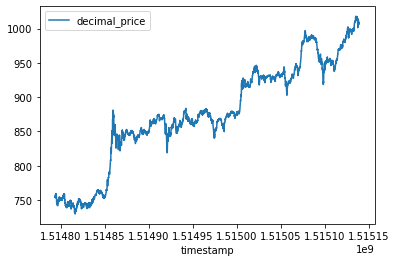

In [9]:
# Recalibrate time variable in a new row to start at 0
# start_time = data['Time'].values[0]
# data['Cal Time'] = data['Time'].apply(lambda x: x - start_time)

# Examples
# Plot data returned
# By default x=index
# data.plot(y='Price', kind='line')
# data.plot(x='Cal Time', y=['Price', 'Plus .3%', 'Minus .3%'], kind='line')
# data.plot(x='Cal Time', y=['Price', 'Plus .3%', 'Minus .3%'], kind='line', xlim=(35000,45000))
# data.plot(x='Cal Time', y=['Price', 'Plus .3%', 'Minus .3%'], kind='line', ylim=(data['Price'].mean()*(1-.005),data['Price'].mean()*(1+.005)))

# testing
data = pd.read_csv(get_test_data_path('test.csv'), index_col='index')
# print(type(data['fraction_price'].values[0]))
# print(dir(data['price'].values[0]))
start_datetime = pd.to_datetime(data['timestamp'].iloc[0], unit='s')
end_datetime = pd.to_datetime(data['timestamp'].iloc[-1], unit='s')
print(f'Start datetime: {start_datetime}')
print(f'End datetime:   {end_datetime}')
data.plot(x='timestamp', y='decimal_price', kind='line')

Start datetime: 2018-01-01 00:01:00
End datetime:   2018-12-31 23:59:00
Start datetime: 2019-01-01 00:01:00
End datetime:   2019-12-31 23:59:00
Start datetime: 2020-01-01 00:01:00
End datetime:   2020-12-31 23:59:00
Start datetime: 2021-01-01 00:01:00
End datetime:   2021-11-26 23:43:00


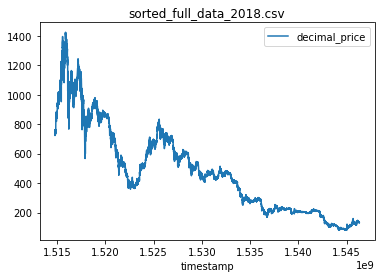

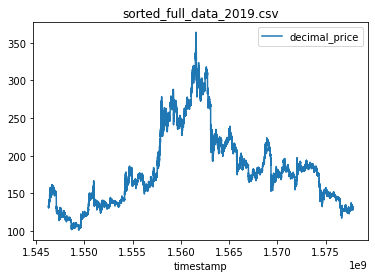

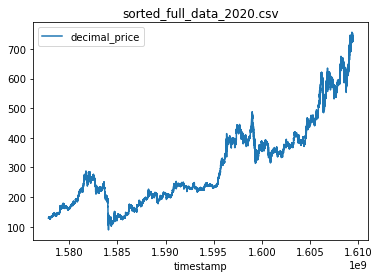

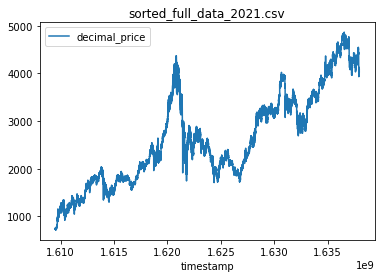

In [10]:
# Yearly Price Plots
for csv in sorted_list_of_csv:
    data = pd.read_csv(bs.full_path(csv), index_col='index')
    start_datetime = pd.to_datetime(data['timestamp'].iloc[0], unit='s')
    end_datetime = pd.to_datetime(data['timestamp'].iloc[-1], unit='s')
    print(f'Start datetime: {start_datetime}')
    print(f'End datetime:   {end_datetime}')
    data.plot(x='timestamp', y='decimal_price', title=csv, kind='line')

Combined_ETH_all_price_data.csv
Start datetime: 2018-01-01 00:00:00
End datetime:   2022-02-16 09:40:00


<AxesSubplot:title={'center':'Combined_ETH_all_price_data.csv'}, xlabel='timestamp'>

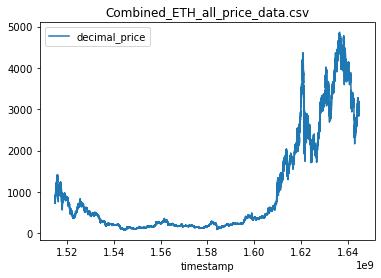

In [11]:
csv = 'Combined_ETH_all_price_data.csv'
print(csv)
data = pd.read_csv(bs.full_path(csv), index_col='index')
start_datetime = pd.to_datetime(data['timestamp'].iloc[0], unit='s')
end_datetime = pd.to_datetime(data['timestamp'].iloc[-1], unit='s')
print(f'Start datetime: {start_datetime}')
print(f'End datetime:   {end_datetime}')
data.plot(x='timestamp', y='decimal_price', title=csv, kind='line')